In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

# pyomo
import importlib
import neural_net_pyomo

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [90]:
data = pd.read_csv('df_train.csv')

data = data[data.settlement_date >= '2010-01-01']
data = data[data.settlement_date < '2011-01-01']
data.reset_index(drop=True, inplace=True)

#display(data.info())
#display(data.isna().sum())

data_subsample = data[:400]
data_subsample.shape

display(data.head())

,settlement_date,temperature,conditions,precip,cloudcover,humidity,windspeed,nd,pump_storage_pumping,is_holiday
0,2010-01-01 00:00:00,2.5,Partially cloudy,0.0,43.6,75.52,16.2,36566.5,264.5,1.0
1,2010-01-01 01:00:00,0.6,Partially cloudy,0.0,36.1,86.19,14.0,35852.5,289.5,1.0
2,2010-01-01 02:00:00,0.8,Partially cloudy,0.0,48.8,85.14,16.7,34189.5,461.0,1.0
3,2010-01-01 03:00:00,0.7,Partially cloudy,0.0,68.1,83.74,13.9,32453.0,1334.0,1.0
4,2010-01-01 04:00:00,0.4,Partially cloudy,0.0,34.5,83.66,12.2,30450.5,1387.5,1.0


In [91]:
data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour

# select the main columns for the intial testing
data_subsample = data_subsample[['temperature', 'hour', 'nd']]
data_subsample.head()

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_27715/480078575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour


,temperature,hour,nd
0,2.5,0,36566.5
1,0.6,1,35852.5
2,0.8,2,34189.5
3,0.7,3,32453.0
4,0.4,4,30450.5


In [92]:
t = jnp.linspace(0., 1., data_subsample.shape[0])

def generate_chebyshev_nodes(n, start, end):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (end - start) * x + 0.5 * (start + end)
    return np.sort(nodes)

In [93]:
# interpolate the whole dataset
cs_temp = CubicSpline(t, data_subsample['temperature'])
cs_hour = CubicSpline(t, data_subsample['hour'])
cs_nd = CubicSpline(t, data_subsample['nd'])

### split, end defitions

In [94]:
split, end = 100, 200
#split, end = 200, 400

t_train = t[:split]
t_test = t[split:end]

In [95]:
# RESAMPLE TO OBTAIN THE CHEBYSHEV NODES
x_train_cheb = generate_chebyshev_nodes(t_train.shape[0], 0, t_train.max())

y_train_temp = cs_temp(x_train_cheb)
y_train_hour = cs_hour(x_train_cheb)
y_train_nd = cs_nd(x_train_cheb)

In [96]:
X_train = np.vstack([y_train_temp, y_train_hour]).T
print(X_train.shape)
X_train = pd.DataFrame(X_train, columns=['temperature', 'hour'])
y_train = pd.DataFrame(y_train_nd)

(100, 2)


In [97]:
data_test = data_subsample[split:end]

X_test = data_test[['temperature', 'hour']]
y_test = data_test['nd']

In [98]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [99]:
t_test.shape

(100,)

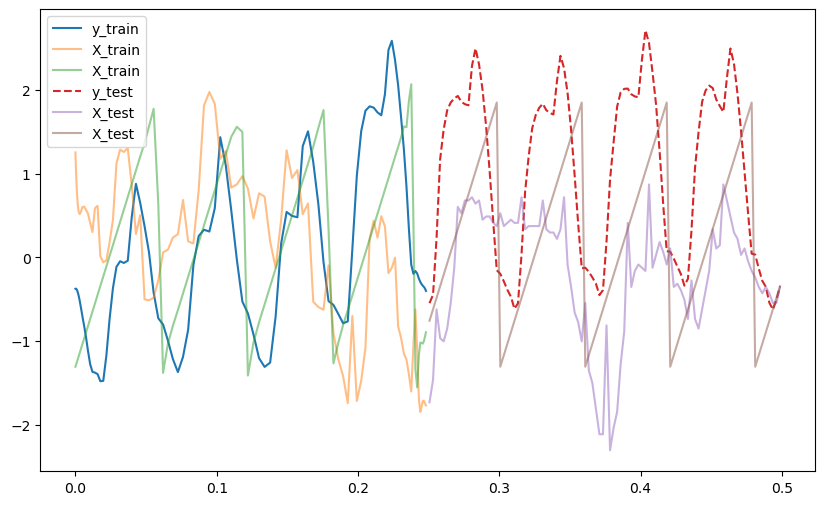

In [100]:
plt.figure(figsize=(10, 6))
#plt.plot(t, data_subsample['temperature'], color='red', label='Original Data')
plt.plot(x_train_cheb, y_train_scaled, label='y_train')
plt.plot(x_train_cheb, X_train_scaled, label='X_train', alpha = 0.5)

plt.plot(t_test, y_test_scaled, label='y_test', ls = '--')
plt.plot(t_test, X_test_scaled, label='X_test', alpha = 0.5)

plt.legend()
plt.show()

In [101]:
weights = compute_weights(x_train_cheb)
D = np.array(lagrange_derivative(x_train_cheb, weights))

In [102]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):
        if x.ndim == 2:
             embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        elif x.ndim == 1:
            embedding = jnp.array([x[i + j * tau] for j in range(m)])     
        else:
            raise ValueError("Input array x must be either 1D or 2D.")
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)

tau = 1
m = 3
embeddings = create_delayed_embeddings(y_train_scaled, tau, m)
print(embeddings.shape)

(97, 3)


`updated version with decorators`

In [103]:
"""import neural_net_pyomo

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo"""

'import neural_net_pyomo\n\nimportlib.reload(neural_net_pyomo)\nNeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo'

`initial model version`

In [104]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

### train the model

In [109]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

# import neural_net_pyomo

# importlib.reload(neural_net_pyomo)
# NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

offset = m*tau
layer_widths = [1 + 2, 30, 1]

# solver.options['print_level'] = 5
tol = 1e-6
params = {"tol":tol, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          #"acceptable_tol": 1e-4,
          #"acceptable_dual_inf_tol": 1e-1,
          #"acceptable_constr_viol_tol": 1e-1,
          #"acceptable_compl_inf_tol": 1e-1,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          # "hessian_approximation": 'limited-memory', 
          # "mu_strategy": 'adaptive', 
          "check_derivatives_for_naninf": 'yes',
          "max_iter": 10000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(y_train_scaled[offset : split]), # y
                           np.array(x_train_cheb[offset : split]), # t
                           np.array(D[offset : split, offset : split]),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = np.array(y_train_scaled[offset : split]), 
                           penalty_lambda_reg = 0.0001, 
                           penalty_lambda_input = 0.01,
                           constraint_penalty = 0.1,  
                           constraint = "l1",
                           
                           extra_input = np.array(X_train_scaled[offset : split]), # X
                           w_init_method = 'random', params = params,
                           )

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: tol=1e-06
dual_inf_tol=1e-06
compl_inf_tol=1e-06
constr_viol_tol=1e-06
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
check_derivatives_for_naninf=yes
max_iter=10000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    24056
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    19754

Total number of variables............................:      248
                     variables with only lower bounds:        0
                variables wi

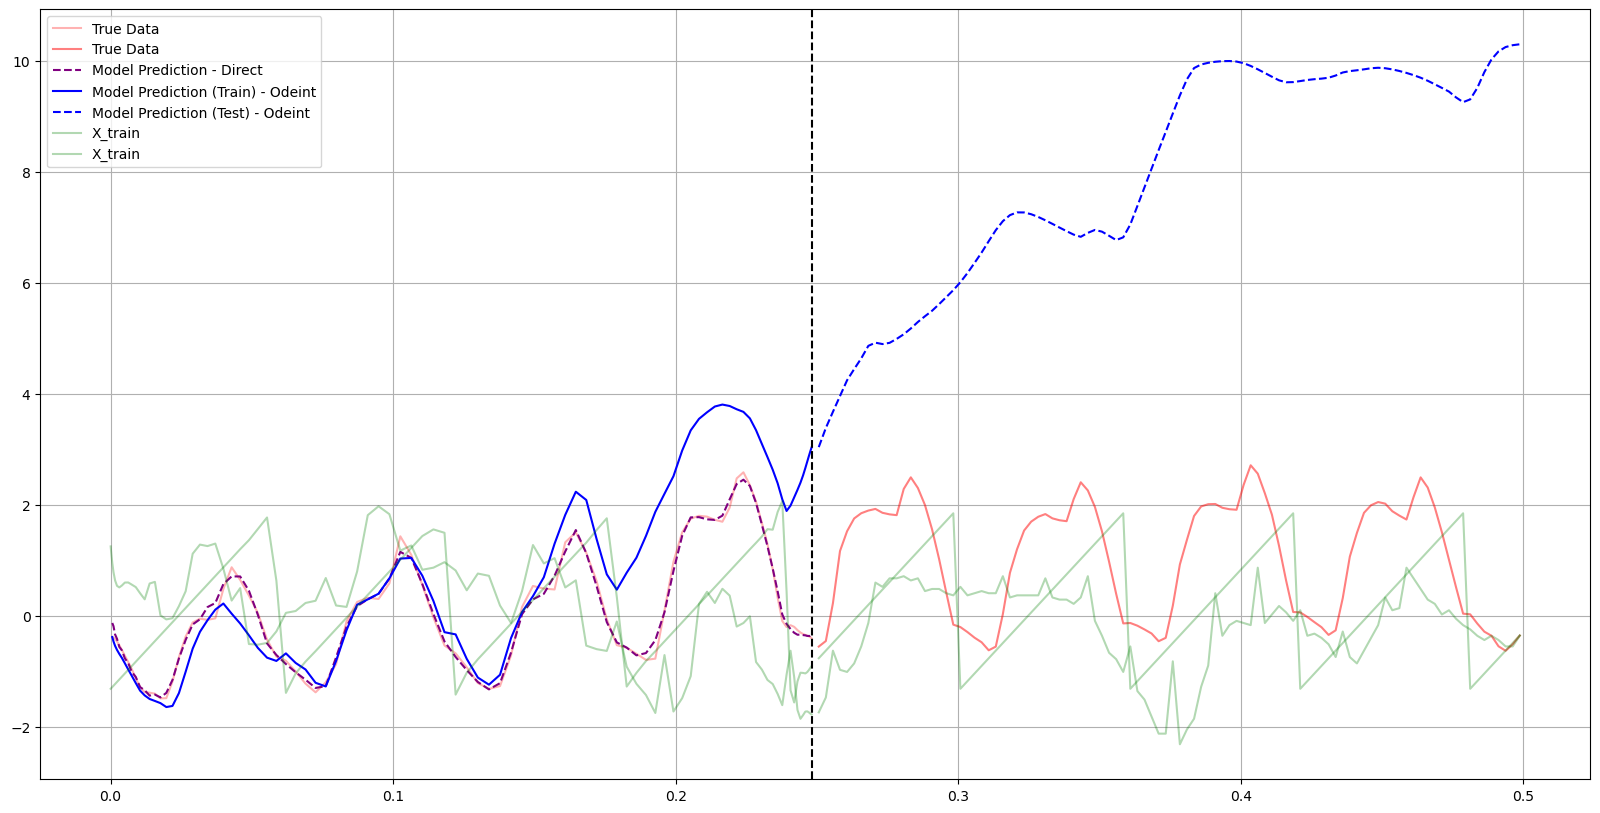

In [112]:
# train
y_init = y_train_scaled[offset : split][0]
t_train = x_train_cheb[offset : split]
extra_args = np.array(X_train_scaled[offset : split])
y_pred = ode_model.neural_ode(y_init, t_train, (extra_args, t_train))

# test
y_init_test = y_pred[-1]
extra_args = np.array(X_test_scaled)
y_pred_test = ode_model.neural_ode(y_init_test, t_test, (extra_args, t_test))

plt.figure(figsize=(20, 10))
plt.plot(x_train_cheb[offset : split], y_train_scaled[offset : split], 'r', label='True Data', alpha = 0.3)
plt.plot(t_test, y_test_scaled, 'r', label='True Data', alpha = 0.5)

plt.plot(x_train_cheb[offset : split], u_model, 'purple', label='Model Prediction - Direct', ls = '--')
plt.plot(t_train, y_pred, 'b', label='Model Prediction (Train) - Odeint')
plt.plot(t_test, y_pred_test, 'b', label='Model Prediction (Test) - Odeint', ls = '--')

plt.plot(x_train_cheb, X_train_scaled, 'g', label='X_train', alpha = 0.3)
plt.plot(t_test, X_test_scaled, 'g', alpha = 0.3)

plt.axvline(x = x_train_cheb[-1], color = 'black', ls = '--')

plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

----

In [107]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

offset = m*tau
layer_widths = [1 + 2, 30, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-6, 
          "dual_inf_tol": 1e-1, 
          "compl_inf_tol": 1e-1,
          "constr_viol_tol": 1e-1, 
          
          # repeat the same for the acceptable tolerances
          #"acceptable_tol": 1e-4,
          #"acceptable_dual_inf_tol": 1e-1,
          #"acceptable_constr_viol_tol": 1e-1,
          #"acceptable_compl_inf_tol": 1e-1,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          # "hessian_approximation": 'limited-memory', 
          # "mu_strategy": 'adaptive', 
          "check_derivatives_for_naninf": 'yes',
          "max_iter": 20000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(y_train_scaled[offset : split]), # y
                           np.array(x_train_cheb[offset : split]), # t
                           np.array(D[offset : split, offset : split]),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = np.array(y_train_scaled[offset : split]), 
                           penalty_lambda_reg = 0.0001, 
                           penalty_lambda_input = 0.01,
                           constraint_penalty = 1e-2,  
                           
                           extra_input = np.array(X_train_scaled[offset : split]), # X
                           w_init_method = 'xavier', params = params
                           )

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: tol=1e-06
dual_inf_tol=0.1
compl_inf_tol=0.1
constr_viol_tol=0.1
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
check_derivatives_for_naninf=yes
max_iter=20000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    24056
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    19754

Total number of variables............................:      248
                     variables with only lower bounds:        0
                variables with low

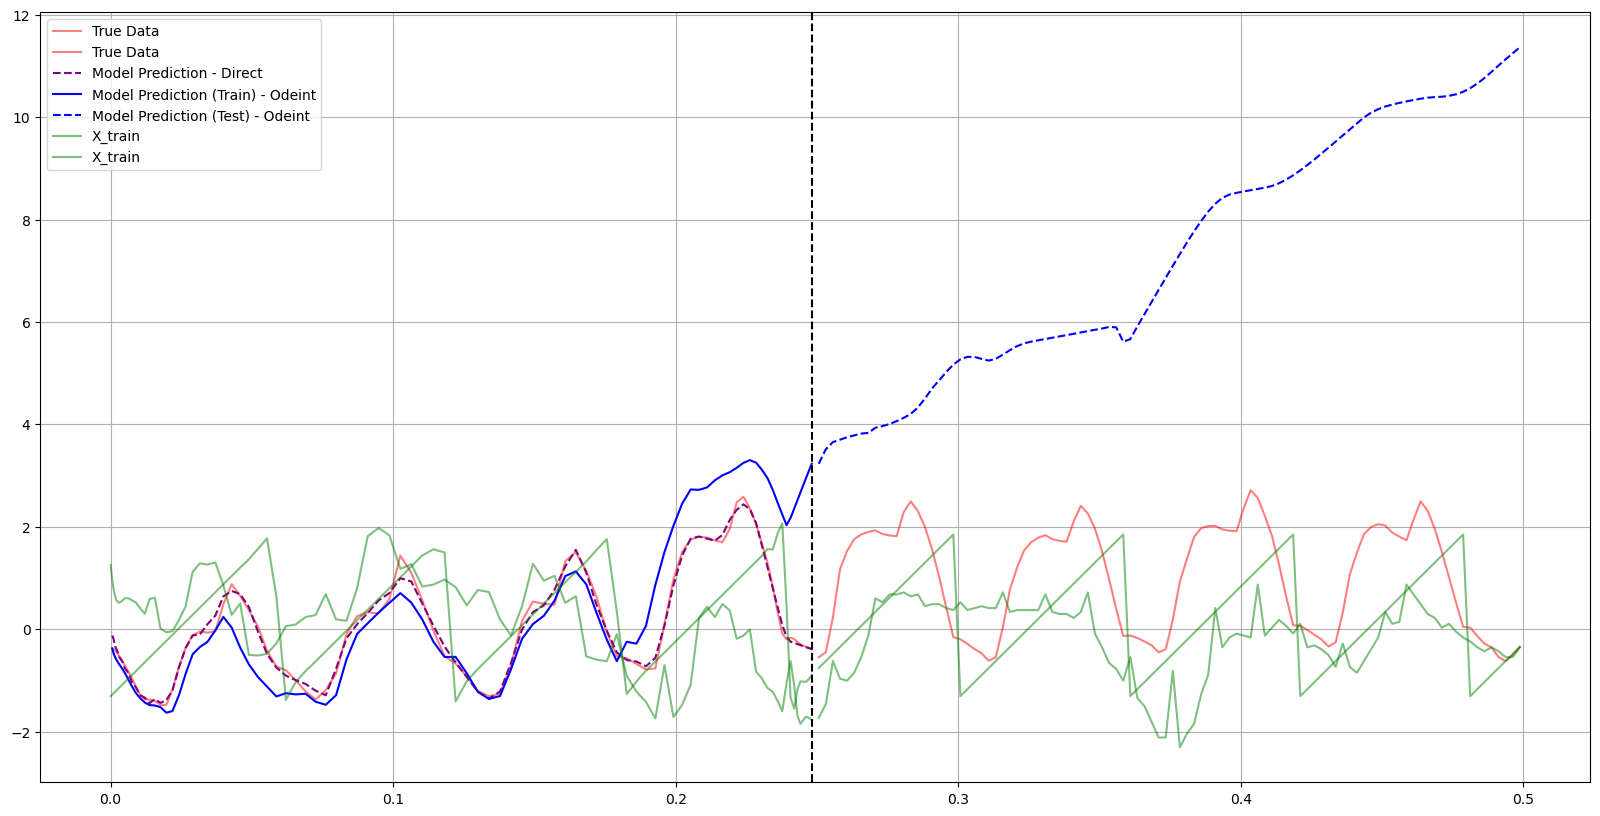

In [108]:
# train
y_init = y_train_scaled[offset : split][0]
t_train = x_train_cheb[offset : split]
extra_args = np.array(X_train_scaled[offset : split])
y_pred = ode_model.neural_ode(y_init, t_train, (extra_args, t_train))

# test
y_init_test = y_pred[-1]
extra_args = np.array(X_test_scaled)
y_pred_test = ode_model.neural_ode(y_init_test, t_test, (extra_args, t_test))

plt.figure(figsize=(20, 10))
plt.plot(x_train_cheb[offset : split], y_train_scaled[offset : split], 'r', label='True Data', alpha = 0.5)
plt.plot(t_test, y_test_scaled, 'r', label='True Data', alpha = 0.5)

plt.plot(x_train_cheb[offset : split], u_model, 'purple', label='Model Prediction - Direct', ls = '--')
plt.plot(t_train, y_pred, 'b', label='Model Prediction (Train) - Odeint')
plt.plot(t_test, y_pred_test, 'b', label='Model Prediction (Test) - Odeint', ls = '--')

plt.plot(x_train_cheb, X_train_scaled, 'g', label='X_train', alpha = 0.5)
plt.plot(t_test, X_test_scaled, 'g', alpha = 0.5)

plt.axvline(x = x_train_cheb[-1], color = 'black', ls = '--')

plt.legend(loc ="upper left")
plt.grid(True)
plt.show()